In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import scienceplots
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.style.use(['ieee','no-latex'])
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 20
warnings.filterwarnings('ignore')
sns.set_style('dark')


# Final Modelling

In [2]:
df = pd.read_csv('train_data_noise.csv')

lower_lim = len(df['ID'].unique())*8//10
X_train = df[df['ID'] <= lower_lim]\
    [['Flow_rate', 'Volume', 'Ca0', 'Cb0', 'Cx0', 'Cyo', 'Czo','Time']]
y_train = df[df['ID'] <= lower_lim][['Caf', 'Cbf', 'Cxf', 'Cyf', 'Czf']]
X_test = df[(lower_lim < df['ID'])]\
    [['Flow_rate', 'Volume', 'Ca0', 'Cb0', 'Cx0', 'Cyo', 'Czo','Time']]
y_test = df[(lower_lim < df['ID'])][['Caf', 'Cbf', 'Cxf', 'Cyf', 'Czf']]

# Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Function to get gradients
def reactor_equations(state, F, V, ca0, cb0, k1=0.0005, k2=0.05, k3=0.02):
    ca, cb, cx, cy, cz = state
    cx0, cy0, cz0 = 0, 0, 0

    dca_dt = F * (ca0 - ca) / V - k1 * ca * cb
    dcb_dt = (F * cb0 - F * cb) / V - k1 * ca * cb - k2 * cb * cx - k3 * cb * cy
    dcx_dt = (F * cx0 - F * cx) / V + k1 * ca * cb - k2 * cb * cx
    dcy_dt = (F * cy0 - F * cy) / V + k2 * cb * cx - k3 * cb * cy
    dcz_dt = (F * cz0 - F * cz) / V + k3 * cy * cb

    return [dca_dt, dcb_dt, dcx_dt, dcy_dt, dcz_dt]

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_nodes, output_size):
        super(ANNModel, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, hidden_nodes), nn.Tanh()]

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.extend([nn.Linear(hidden_nodes, hidden_nodes), nn.Tanh()])

        # Output layer
        self.layers.append(nn.Linear(hidden_nodes, output_size))

        # Create the sequential model
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)
    
    def pinns_loss(self, batch_X ,model_output, batch_y):

        batch_X = scaler_X.inverse_transform(batch_X)
        batch_y = scaler_y.inverse_transform(batch_y)
        model_output = scaler_y.inverse_transform(model_output.detach().numpy())

        batch_X = torch.tensor(batch_X, dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)
        model_output = torch.tensor(model_output, dtype=torch.float32).to(device)

        # Compute the loss at the boundary conditions
        F, V, Ca0, Cb0, *feats = batch_X.T
        time = batch_X[:,-1]
        ca, cb, cx, cy, cz = model_output.T

        # Calculate gradients 
        dca_dt = (ca[1:] - ca[:-1]) / (time[1:] - time[:-1])
        dcb_dt = (cb[1:] - cb[:-1]) / (time[1:] - time[:-1])
        dcx_dt = (cx[1:] - cx[:-1]) / (time[1:] - time[:-1])
        dcy_dt = (cy[1:] - cy[:-1]) / (time[1:] - time[:-1])
        dcz_dt = (cz[1:] - cz[:-1]) / (time[1:] - time[:-1])

        # Calculate truth values using reactor_equations function
        truth_values = reactor_equations(batch_y[1:].T, F[1:], V[1:], Ca0[1:], Cb0[1:])
        truth_dca_dt, truth_dcb_dt, truth_dcx_dt, truth_dcy_dt, truth_dcz_dt = truth_values

        # Compute L2 norm of the difference between gradients
        gradient_loss = torch.nn.functional.mse_loss(dca_dt, truth_dca_dt) + \
                        torch.nn.functional.mse_loss(dcb_dt, truth_dcb_dt) + \
                        torch.nn.functional.mse_loss(dcx_dt, truth_dcx_dt) + \
                        torch.nn.functional.mse_loss(dcy_dt, truth_dcy_dt) + \
                        torch.nn.functional.mse_loss(dcz_dt, truth_dcz_dt)

        # Total loss
        return gradient_loss

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# Parameters
input_size = X_train_tensor.shape[1]
hidden_layers = 4
hidden_nodes = 512
output_size = 5
batch_size = 500
num_epochs = 50

# Initialize the PyTorch model, loss function, and optimizer
model = ANNModel(input_size, hidden_layers, hidden_nodes, output_size).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

# DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# Lists to store training history
mse_history_train = []
r2_history_train = []
mse_history_val = []
r2_history_val = []

# Training loop
progress_bar = tqdm(range(num_epochs), desc="Training")

for epoch in progress_bar:

    # Training
    model.train()
    for batch_X, batch_y in train_loader:

        # Compute the model output
        model_output = model(batch_X)

        # Compute the PINNs loss 
        pinns_loss = 100*model.pinns_loss(batch_X, model_output, batch_y)

        # Total loss 
        loss = criterion(model_output, batch_y) + pinns_loss

        # Update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        # Predict on training set
        y_train_pred = model(X_train_tensor).cpu().numpy()
        y_train_pred = scaler_y.inverse_transform(y_train_pred)

        # Predict on validation set
        y_val_pred = model(X_test_tensor).cpu().numpy()
        y_val_pred = scaler_y.inverse_transform(y_val_pred)

        # Calculate metrics
        mse_train = mean_squared_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        mse_val = mean_squared_error(y_test, y_val_pred)
        r2_val = r2_score(y_test, y_val_pred)

        # Append metrics to history
        mse_history_train.append(mse_train)
        r2_history_train.append(r2_train)
        mse_history_val.append(mse_val)
        r2_history_val.append(r2_val)

    progress_bar.set_postfix({'MSE Loss': float(criterion(model_output, batch_y)), 
                              'PINNs loss': float(pinns_loss), 'R2 (Train)': r2_train, 
                              'R2 (Val)': r2_val})

Training: 100%|██████████| 50/50 [4:46:48<00:00, 344.17s/it, MSE Loss=0.00142, PINNs loss=7.89, R2 (Train)=0.944, R2 (Val)=0.98]   


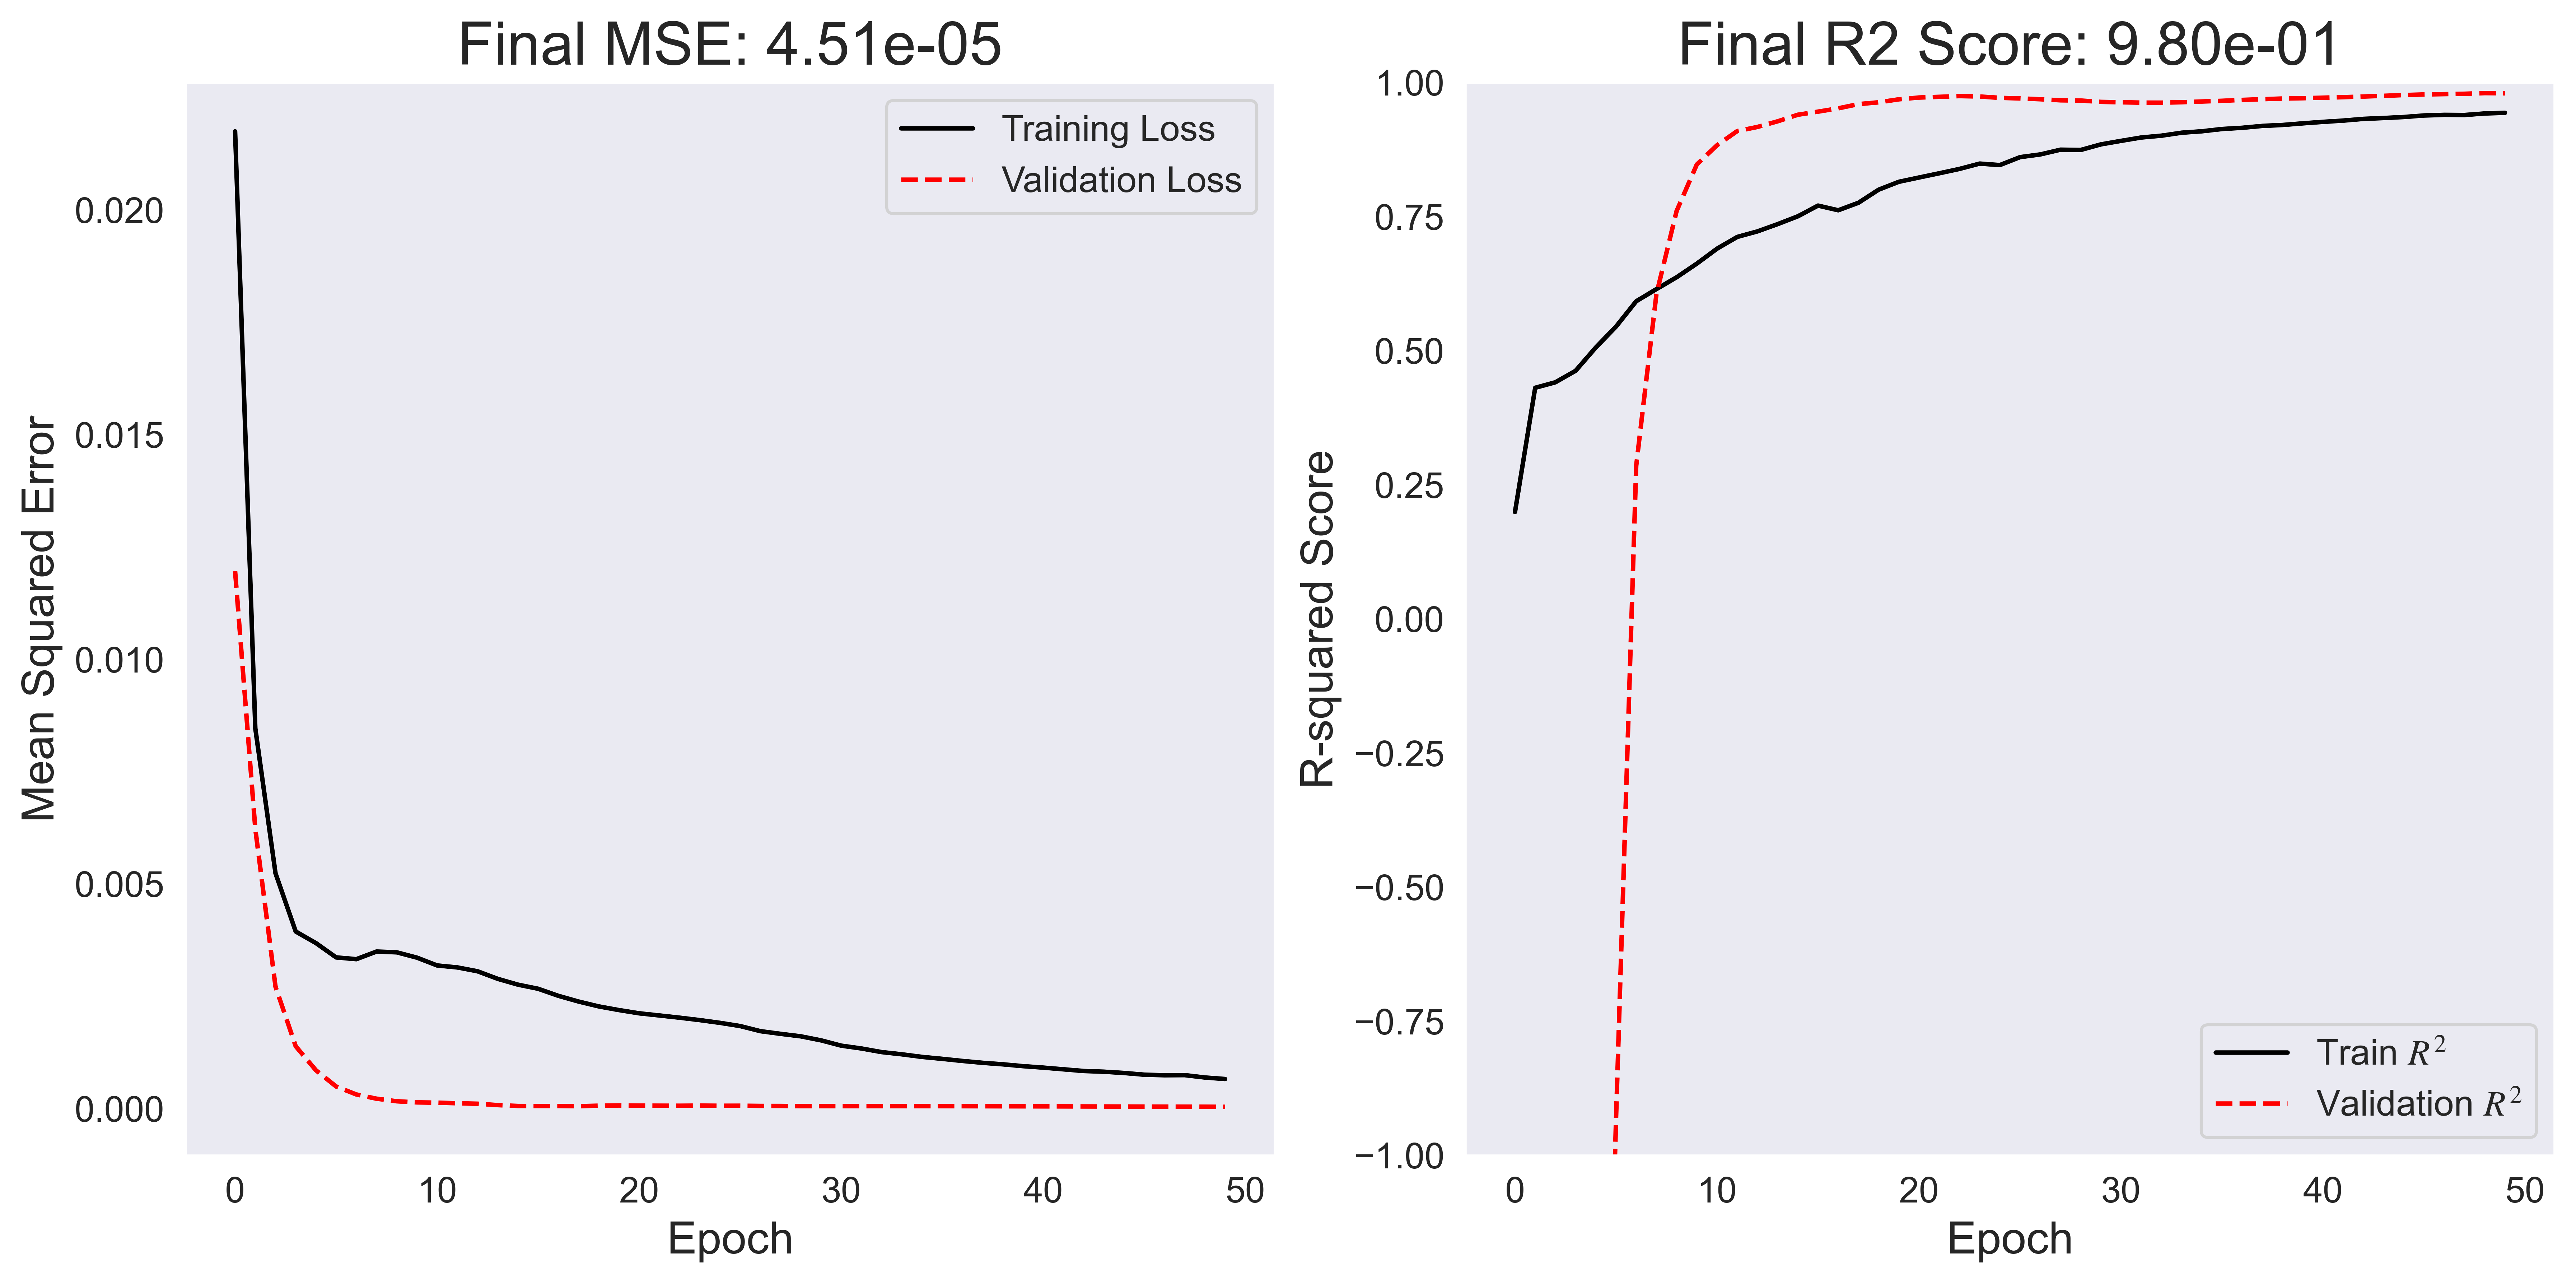

In [3]:
# Plot training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mse_history_train, label='Training Loss')
plt.plot(mse_history_val, label='Validation Loss')
plt.title(f'Final MSE: {mse_history_val[-1]:.2e}')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot training and validation R2 score over epochs
plt.subplot(1, 2, 2)
plt.plot(r2_history_train, label='Train $R^2$')
plt.plot(r2_history_val, label='Validation $R^2$')
plt.title(f'Final R2 Score: {r2_history_val[-1]:.2e}')
plt.xlabel('Epoch')
plt.ylabel('R-squared Score')
plt.ylim(-1,1)
plt.legend()

plt.tight_layout()
plt.show()

# Extract features for the new test set
features_test = X_test.iloc[-5*500:,:]

# Standardize features
features_test_scaled = scaler_X.transform(features_test)

# Convert to PyTorch tensor
X_tensor = torch.tensor(features_test_scaled, dtype=torch.float32).to(device)

# Ensure the model is in evaluation mode
model.eval()

# Predict concentrations using the trained model
with torch.no_grad():
    y_pred_test_scaled = model(X_tensor).cpu().numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)

# Plot actual concentration values and predicted concentration values against time
time_values = range(y_test.iloc[-5*500:,:].shape[0])

plt.figure(figsize=(12, 20))
for i, col in enumerate(y_test.iloc[-5*500:,:].columns):
    plt.subplot(5, 1, i + 1)
    plt.plot(time_values, y_test.iloc[-5*500:,:][col], '.', label='Actual', alpha=0.5)
    plt.plot(time_values, y_pred_test[:, i], '.', label='Predicted', alpha=0.5)
    plt.title(f'Actual vs Predicted {col}')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend()

plt.tight_layout()
plt.show()